In [4]:
import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

In [5]:
batch_size = 100
img_height = 250
img_width = 250

In [6]:
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/collision avoidance dataset/data/train',
    seed=101,
    image_size= (img_height, img_width),
    batch_size=batch_size

)

testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/collision avoidance dataset/data/test',
    seed=101,
    image_size= (img_height, img_width),
    batch_size=batch_size)

validation_ds =  tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/collision avoidance dataset/data/val',
    seed=101,
    image_size= (img_height, img_width),
    batch_size=batch_size)

Found 791 files belonging to 2 classes.
Found 100 files belonging to 2 classes.
Found 98 files belonging to 2 classes.


In [7]:
class_names = training_ds.class_names

## Configuring dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_ds = training_ds.cache().prefetch(buffer_size=AUTOTUNE)
testing_ds = testing_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
img_shape = (img_height, img_width, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [9]:
model = tf.keras.Sequential([
    base_model,
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D((1, 1)),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D((1, 1)),
    layers.Conv2D(128, 3, activation='relu'),
    layers.Flatten(),
    layers.Dense(len(class_names), activation='softmax')
])

In [10]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [11]:
history = model.fit(training_ds, validation_data = validation_ds, epochs = 10)

Epoch 1/10
8/8 [==============================] - 153s 9s/step - loss: 0.9539 - accuracy: 0.5575 - val_loss: 0.6433 - val_accuracy: 0.6327
Epoch 2/10
8/8 [==============================] - 57s 7s/step - loss: 0.5535 - accuracy: 0.7396 - val_loss: 0.4934 - val_accuracy: 0.8265
Epoch 3/10
8/8 [==============================] - 65s 9s/step - loss: 0.3934 - accuracy: 0.8420 - val_loss: 0.4120 - val_accuracy: 0.7959
Epoch 4/10
8/8 [==============================] - 59s 8s/step - loss: 0.2467 - accuracy: 0.9064 - val_loss: 0.3307 - val_accuracy: 0.8673
Epoch 5/10
8/8 [==============================] - 56s 7s/step - loss: 0.1425 - accuracy: 0.9507 - val_loss: 0.2702 - val_accuracy: 0.8673
Epoch 6/10
8/8 [==============================] - 62s 8s/step - loss: 0.0751 - accuracy: 0.9747 - val_loss: 0.2644 - val_accuracy: 0.8980
Epoch 7/10
8/8 [==============================] - 54s 7s/step - loss: 0.0612 - accuracy: 0.9836 - val_loss: 0.3014 - val_accuracy: 0.8878
Epoch 8/10
8/8 [=================

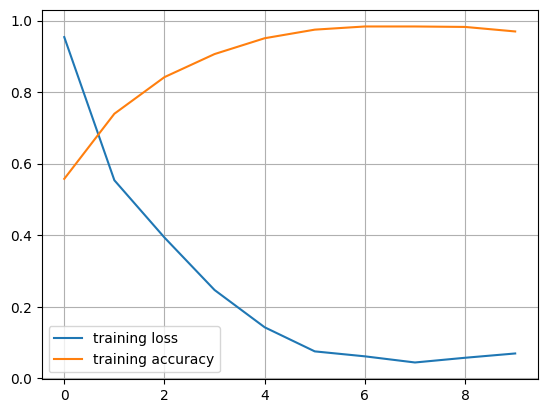

In [12]:
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.grid(True)
plt.legend()

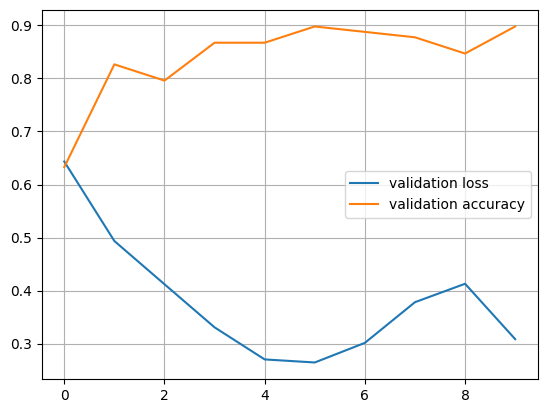

In [13]:
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.grid(True)
plt.legend()

In [14]:
print(class_names)

['Accident', 'Non Accident']


In [15]:
!pip install youtube_dl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 10.5 MB/s eta 0:00:00


In [16]:
!pip install twilio

In [17]:
# prompt: convert model to the pickle file

import pickle

# Save the trained model as a pickle string.
model_string = pickle.dumps(model)

# Write the model string to a file.
with open('model.pkl', 'wb') as f:
  f.write(model_string)


In [18]:
import os

current_working_directory = os.getcwd()

# List all files in the current working directory
files = os.listdir(current_working_directory)

# Check if any of the files end with ".pkl"
pickle_files = [f for f in files if f.endswith(".pkl")]

# Print the list of pickle files
if pickle_files:
    print("Pickle files found:", pickle_files)
else:
    print("No pickle files found in the current working directory.")

Pickle files found: ['model.pkl']


In [19]:
import joblib
joblib.dump(model,'model_namk.pkl')

['model_namk.pkl']

In [21]:
import cv2
import tensorflow as tf
from twilio.rest import Client

# Load the collision avoidance model
model = joblib.load('model_namk.pkl')

# Twilio credentials
account_sid = 'AC1bbb269520ed1a17c60761c4c604a9'
auth_token = 'b6d0077b9c3f54b77642d54f794ceye7'
from_number = '+13342924424'
to_number = '+918112976994'

# Function to send message using Twilio
def send_message(message):
    client = Client(account_sid, auth_token)
    message = client.messages.create(
        body=message,
        from_=from_number,
        to=to_number
    )
    print(f'Message sent: {message.sid}')

def preprocess_frame(frame):
    # Resize frame to match model input size (250x250)
    resized_frame = cv2.resize(frame, (img_height, img_width))
    # Normalize pixel values to be between 0 and 1
    normalized_frame = resized_frame / 255.0
    return normalized_frame

def predict_accident(frame):
    # Preprocess frame
    preprocessed_frame = preprocess_frame(frame)
    # Expand dimensions to match model input shape (add batch dimension)
    input_tensor = tf.expand_dims(preprocessed_frame, axis=0)
    # Make prediction using the model
    prediction = model.predict(input_tensor)
    # Extract prediction probability for accident class (index 1)
    accident_probability = prediction[0][1]
    return accident_probability


# Open the video file
video_path = ('/content/drive/MyDrive/CDD2/videos/testing/positive/000456.mp4')
cap = cv2.VideoCapture(video_path)

# Loop through each frame
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Resize frame to match model input size (if needed)
    # Predict if an accident occurs
    prediction = predict_accident(frame)

    # If accident is detected, stop the video and send message
    if prediction > 0.5:  # Adjust threshold as needed
        cap.release()  # Stop video playback
        send_message("Accident Detected!")  # Send message using Twilio
        break

# Release the video capture object
cap.release()


1/1 [==============================] - 1s 1s/step
Message sent: SM3c8958319292e0d55eb7aaf8e8b8ded8
